In [13]:
import pandas as pd
import mysql.connector
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# First buyer: Top 5 romance genre author

In [2]:
db = mysql.connector.connect(
   host="localhost",
  user="root",
  password="Ben1204",
  database="Booktopia")
mycursor = db.cursor()

In [40]:
sql_quary = """
            SELECT DISTINCT wp.name,
                ((avg(score) - 3.5) / (4.4 - 3.5)) * 0.8 +
                ((count(reward) - 1) / (39 - 1)) * 0.4 +
                ((avg(edition / (2024 - (bd.ad_publication_year))) - 0.1) / (13.2 - 0.1)) * 0.6
                AS writer_score
            FROM book_detail bd
            INNER JOIN book_summary bs ON bs.site_id = bd.site_id
            INNER JOIN writer w ON w.site_id = bs.site_id
            INNER JOIN writer_page wp ON wp.writer_id = w.writer_id
            INNER JOIN translator t ON t.book_id = bd.book_id
            INNER JOIN translator_page tp ON tp.translator_id = t.translator_id
            INNER JOIN rewards r ON r.site_id = bd.site_id
            INNER JOIN book_tag bt ON bt.site_id = bd.site_id
            INNER JOIN tags ta ON ta.id = bt.tag_id
            WHERE bd.book_language = 'فارسی'
            AND ta.name IN ('داستان عاشقانه', 'داستان درام', 'فهرست بهترین رمان های عاشقانه')
            AND bd.ad_publication_year BETWEEN 1800 AND 2023
            AND edition != -1
            GROUP BY t.translator_id
            ORDER BY writer_score DESC
            LIMIT 5;
        """
mycursor.execute(sql_quary)

- In order to determine the appropriate criteria for ranking authors, we used the rating of each book, the number of awards, and the series editions of each book, taking into account the number of years since its publication (so that newly emerging books are also adequately valued).
- َ The data has been normalized for a better scale.

In [41]:
# adding result of quary to dataframe 
columns = [i[0] for i in mycursor.description]
result = mycursor.fetchall()
df = pd.DataFrame(result, columns=columns)
df


,name,writer_score
0,اونوره دو بالزاک,1.0373801526718
1,جوجو مویز,1.0111789652248
2,فردریک بکمن,0.9736222890151
3,انجی توماس,0.9722679655379
4,کالین هوور,0.8906446140797


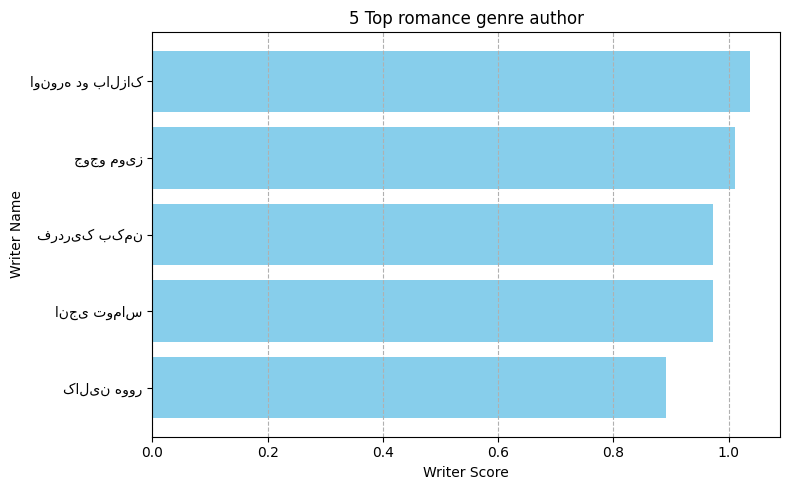

In [14]:
# Plot data
plt.figure(figsize=(8, 5))  
plt.barh(df['name'], df['writer_score'], color='skyblue')
plt.xlabel('Writer Score')
plt.ylabel('Writer Name')
plt.title('5 Top romance genre author')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.grid(axis='x', linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

# The writer's request :5 Top historical publisher


In [29]:
db = mysql.connector.connect(
   host="localhost",
  user="root",
  password="Ben1204",
  database="Booktopia")
mycursor = db.cursor()

In [36]:
sql_quary = """
SELECT p.name AS publisher_name,(
    ((AVG(bd.score) - 3) / (5 - 3)) * 0.5+
    ((COUNT(*) - 1) / (216 - 1)) * 0.8) AS publisher_score
FROM book_detail AS bd
JOIN publisher AS p ON bd.publisher_id = p.id
JOIN book_tag AS bt ON bd.site_id = bt.site_id
JOIN tags AS t ON bt.tag_id = t.id
WHERE t.name in ('داستان تاریخی درام' ,'تاریخی')
GROUP BY p.id, p.name
ORDER BY publisher_score DESC
limit 5  ;
"""
mycursor .execute(sql_quary)

- Our criterion for determining the best publications is the average ratings of published books and the number of books published in this genre.
- The data has been normalized for a better scale .


In [37]:
# adding result of quary to dataframe
column = [k[0] for k in mycursor .description]
results = mycursor .fetchall()
df1 = pd.DataFrame(results, columns=column)
df1


,publisher_name,publisher_score
0,ققنوس,0.90453703700
1,علم,0.69283629695
2,علمی و فرهنگی,0.64686859605
3,نشر نی,0.62456062410
4,شیرازه,0.59986434085


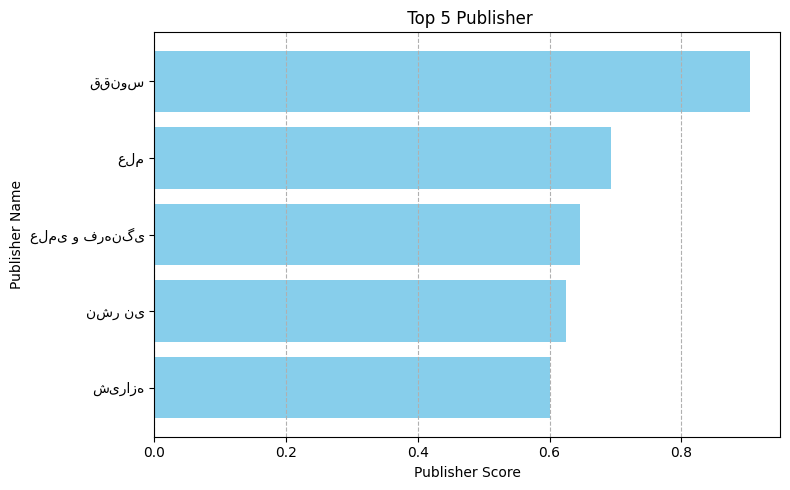

In [38]:
#plot data
plt.figure(figsize=(8, 5))  
plt.barh(df1['publisher_name'], df1['publisher_score'], color='skyblue')
plt.xlabel('Publisher Score')
plt.ylabel('Publisher Name')
plt.title(' Top 5 Publisher')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.grid(axis='x', linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

# First hypothesis :

In [19]:
db = mysql.connector.connect(
   host="localhost",
  user="root",
  password="Ben1204",
  database="Booktopia")
mycursor = db.cursor()

In [20]:
sql_quary = """
            select bd.english_title as book_name , ph.price as price
            from book_detail bd
            inner join Price_history ph on ph.book_id = bd.book_id
            where bd.book_language ='انگلیسی' and bd.stock_status = ' موجود 'and bd.cover_id = 0
            group by bd.english_title, ph.price
            order by price desc ;
            """
mycursor.execute(sql_quary)

In [21]:
# adding result of quary to dataframe
columns = [i[0] for i in mycursor.description]
result = mycursor.fetchall()
dfenglish = pd.DataFrame(result, columns=columns)

In [22]:
sql_quary = """
            select bd.english_title as book_name , ph.price as price
            from book_detail bd
            inner join Price_history ph on ph.book_id = bd.book_id
            where bd.book_language ='فارسی' and bd.stock_status =  ' موجود 'and bd.cover_id = 0
            group by bd.english_title, ph.price
            order by price desc ;
            
            """
mycursor.execute(sql_quary)

In [23]:
# adding result of quary to dataframe
column = [k[0] for k in mycursor.description]
results = mycursor.fetchall()
dfpersian = pd.DataFrame(results, columns=column)


In [26]:
# just get common book between translated persian book and english book to improve statical sample
common_book_pe = dfpersian[dfpersian['book_name'].isin(dfenglish['book_name'])]
common_book_en = dfenglish[dfenglish['book_name'].isin(dfpersian['book_name'])]

price_english = common_book_en['price'].tolist()
price_persian = common_book_pe['price'].tolist()

In [27]:
t_statistic, p_value = ttest_ind(price_persian,price_english, equal_var=False)
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -1.1231592100568097
P-Value: 0.2644471642744679


- The t-statistic is a measure to indicate the difference the means .
-  In this case the t-statistic is approximately -1.123. Since this value is negative,it's explain that the price of persian books (translated book ) are slightly lower than the prices of English books.
- P-Value: The p-value is a crucial component of hypothesis test.
- In this case the P-Value is 0.2644471642744679 that is  is greater than 0.05.
- So the p-value suggests that there isn't enough evidence to reject the null hypothesis, meaning that you don't have strong statistical evidence to conclude that there is a significant difference in book prices between English and Persian books.
- A slight price difference may be due to a reduction in the number of pages in the book after translation or the fact that the publisher is not Iranian( Dollar price :) )


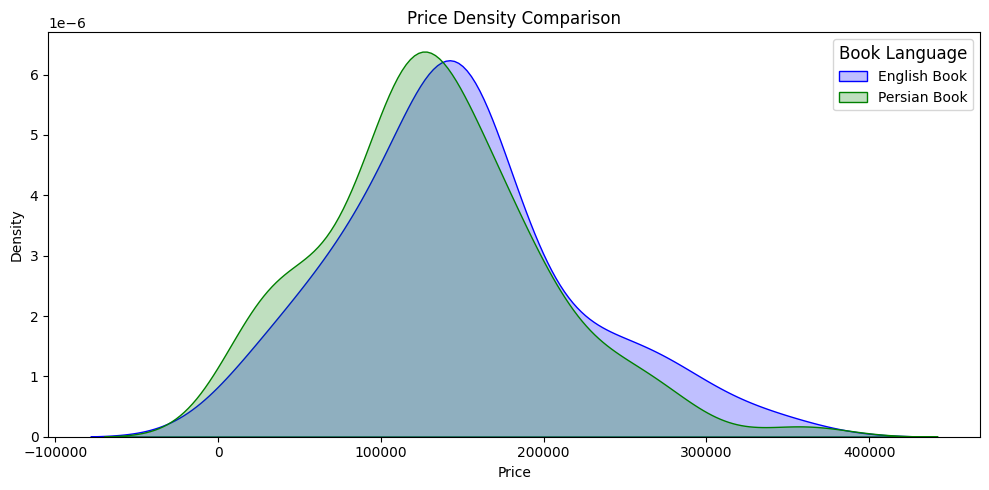

In [28]:
# plot data
plt.figure(figsize=(10, 5))
sns.kdeplot(data=common_book_en, x="price", fill=True, common_norm=False, color="blue", label="English Book")
sns.kdeplot(data=common_book_pe, x="price", fill=True, common_norm=False, color="green", label="Persian Book")
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Price Density Comparison')
plt.tight_layout()
legend = plt.legend(title="Book Language", loc="upper right")
legend.get_title().set_fontsize(12)
plt.show()


-As can also be seen from the chart, it is not possible to discern the difference between the prices of translated and untranslated books with the naked eye, and this difference is negligible.